In [1]:
import uproot
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist as hephist
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from sklearn.gaussian_process import GaussianProcessRegressor 
import scipy.optimize
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
import scipy.stats
from scipy import integrate as intg 
from scipy.integrate import trapz, simps, quad
import math
from uncertainties import ufloat
import seaborn as sns
#sns.set_theme()
#df = sns.load_dataset("penguins")
from numba import njit
import random

#%matplotlib inline
%matplotlib widget

import ROOT
from ROOT import TH1D, TCanvas,TH2D

Welcome to JupyROOT 6.24/06


In [2]:
from  help_class.model import gpr_model

In [3]:
file_mix = uproot.open("../../root_files/reduced_RS67_3087all_target_looseDumpcut_mixed.root",object_cache=1000)
result_mix_tree = file_mix['result_mix']




In [4]:


df_mix = result_mix_tree.arrays(library="pd")
df_mix.head()


# df_jpsi = jpsi_tree.arrays(library="pd")
# df_psip = psiprime_tree.arrays(library="pd")
# df_jpsi.head()

,runID,spillID,D1,D2,D3,ptrk_D1,ptrk_D2,ptrk_occuD3m,ptrk_occuD3p,ptrk_rfp00c,...,nHits2St2,nHits2St3,chisq1,chisq1_upstream,chisq1_target,chisq1_dump,chisq2,chisq2_upstream,chisq2_target,chisq2_dump
0,12525,0,456,322,291,456,409,181,184,2810.629883,...,6,6,0.397684,19.524889,2.469061,3.332003,0.089177,54.043510,25.042723,2.672948
1,12525,0,421,175,304,421,129,125,76,2938.629883,...,6,6,0.035832,65.199501,39.801231,13.261414,0.059105,32.445686,16.724571,2.662155
2,12525,0,408,223,195,408,148,108,69,2490.629883,...,5,5,1.895329,36.089046,7.406844,7.827204,0.998962,31.977947,13.622578,0.785332
3,12525,0,404,256,271,404,231,94,128,1466.630005,...,4,5,0.050199,70.748695,38.634769,4.292117,21.277458,125.886948,56.097191,21.235260
4,12525,0,400,273,461,400,238,209,391,1402.630005,...,5,6,0.144978,58.851456,25.987146,1.432039,0.370238,55.713688,31.500626,8.383695


# Dump Data Cuts

In [44]:



def Dump_PosTrk_cut(df_p):
    ptrk_chisq_mask = (df_p['chisq1_dump']<40.) & (df_p['chisq1_dump']>0.) &\
                         (df_p['chisq1_target'] >5.) & (df_p['chisq1_upstream']>20.)&\
                         (df_p['nHits1']>13)
    
    ptrk_mom_mask = (df_p['pz1_st1']>10) & (df_p['pz1_st1']<80) &\
                    (np.fabs(df_p['py1_st1']-df_p['py1_st3']) < 0.008) &\
                    (np.fabs(df_p['pz1_st1']-df_p['pz1_st3']) < 0.05)
                         
    ptrk_pos_mask = (df_p['z1_v']<250) & (df_p['z1_v']>-50) &\
                    (df_p['y1_st1']/df_p['y1_st3']<1) &\
                    ((df_p['x1_t']**2+(df_p['y1_t']-1.6)**2)<1500) & ((df_p['x1_t']**2+(df_p['y1_t']-1.6)**2)>15) &\
                    ((df_p['x1_d']**2+(df_p['y1_d']-1.6)**2)<300)
                   
    return (ptrk_chisq_mask) & ( ptrk_mom_mask) & (ptrk_pos_mask )
    
    
    
def Dump_NegTrk_cut(df_n):    
    ntrk_chisq_mask = (df_n['chisq2_dump']<40.) & (df_n['chisq2_dump']>0.) &\
                         (df_n['chisq2_target'] >5.) & (df_n['chisq2_upstream']>20.)&\
                         (df_n['nHits2']>13)
    
    ntrk_mom_mask = (df_n['pz2_st1']>10) & (df_n['pz2_st1']<80) &\
                    (np.fabs(df_n['py2_st1']-df_n['py2_st3']) < 0.008) &\
                    (np.fabs(df_n['pz2_st1']-df_n['pz2_st3']) < 0.05)
                         
    ntrk_pos_mask = (df_n['z2_v']<250) & (df_n['z2_v']>-50) &\
                    (df_n['y2_st1']/df_n['y2_st3']<1) &\
                    ((df_n['x2_t']**2+(df_n['y2_t']-1.6)**2)<1500) & ((df_n['x2_t']**2+(df_n['y2_t']-1.6)**2)>15) &\
                    ((df_n['x2_d']**2+(df_n['y2_d']-1.6)**2)<300)
    
    return (ntrk_chisq_mask) & (ntrk_mom_mask) & (ntrk_pos_mask)


def Dump_dim_cut(df_d): 
    vtx_mask =   (df_d['dz'] > -10.) & (df_d['dz'] < 250.) &\
                  (np.fabs(df_d['dx'])<0.45) & (np.fabs(df_d['dy']-1.6)<0.40) &\
                  ((df_d['dx']**2+(df_d['dy']-1.6)**2)<0.2)
    
    mom_mask = (np.fabs(df_d['dpx'])<1.5) & (np.fabs(df_d['dpy'])<3.5) &\
                (np.fabs(df_d['dpz'])<118) & (np.fabs(df_d['dpz'])>35.) &\
                ((df_d['dpx']**2 + df_d['dpy']**2) < 5.)
    
    both_trk_mask = (np.fabs(df_d['trackSeparation']) < 200.) &\
                    (np.fabs(df_d['x1_st1']+df_d['x2_st1'])<20.) & ((df_d['nHits1']+df_d['nHits2'])>29) &\
                    ((df_d['nHits1St1']+df_d['nHits2St1'])>8)

    chisq_mask = (df_d['chisq_dimuon'] < 20.) & (df_d['chisq_dimuon']>0.)
                

    return (vtx_mask) & (mom_mask) & (both_trk_mask) & (chisq_mask)
    
def Dump_Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['costh'])<0.5) &\
                    (df_ph['xF'] > 0.2) & (df_ph['xF'] < .95) &\
                    (df_ph['mass']<10.) & (df_ph['mass']>0.1)
    return phycs_mask
    
    
def Dump_Occu_cut(df_):                   
    occu_mask = (df_['D1']<400) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask

## Fill the Histogram

In [6]:
xmin = 1. # GeV
xmax = 9. # GeV
step_size = 0.1 # GeV
    
bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
def fill_hist(data):
    data_x,_ = np.histogram(data, 
                               bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt(data_x) # statistical error on the data
    
    return data_x, data_x_errors

In [38]:
def plot_gpr(bin_centres, m, m_err, gpr_predict, gpr_sigma):
    fig = plt.figure(figsize=(10,6))

    plt.errorbar(x=bin_centres, y = m, yerr=m_err, fmt='o', color="blue",label="Mixed Data")

    pred_axes = plt.gca()
    pred_axes.plot(bin_centres,gpr_predict, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)

    pred_axes.fill_between(
        bin_centres.ravel(),
        gpr_predict - 1.96 * gpr_sigma,
        gpr_predict + 1.96 * gpr_sigma,
        alpha=0.5,
        label=r"95% confidence interval",
        color='orange'
    )
    plt.legend()
    plt.legend(prop={'size':15})
    plt.xticks(np.arange(xmin, xmax+1, 1.0))
    plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                            x=1, horizontalalignment='right', 
                            fontsize=18 ) 
    plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
    plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
    plt.ylim(bottom=-20000.0)
    plt.grid(True)
    plt.show()

In [39]:
Dump_mix_PosTrk_cut = Dump_PosTrk_cut(df_mix)
Dump_mix_NegTrk_cut = Dump_NegTrk_cut(df_mix)
Dump_mix_Physics_cut = Dump_Physics_cut(df_mix)
Dump_mix_Occu_cut = Dump_Occu_cut(df_mix)
Dump_mix_dim_cut = Dump_dim_cut(df_mix)

Dump_mix_data_cut = (Dump_mix_PosTrk_cut) & (Dump_mix_NegTrk_cut) & (Dump_mix_Physics_cut)  & (Dump_mix_dim_cut)

In [40]:
mix_mass=df_mix['mass'][Dump_mix_data_cut]

mix_m, mix_m_err = fill_hist(mix_mass)

In [41]:

sideband = np.array([1.8, 2.5, 4.5, 7.])
real_data_model = gpr_model()

In [42]:
stacked_mix_m=np.column_stack((np.array(bin_centres),np.array(mix_m), np.array(mix_m_err)))
real_data_model.set_sideband(sideband,stacked_mix_m)
real_data_model.set_kernel(50000.0, (1e-10, 1e15),5,(1e-4, 1e15))
Y_pred, sigma, gpr_error = real_data_model.predict(5000)

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  9.2e+04**2 * RBF(length_scale=0.889)
score =  0.9801579357281627
Log-likelihood: -243.488


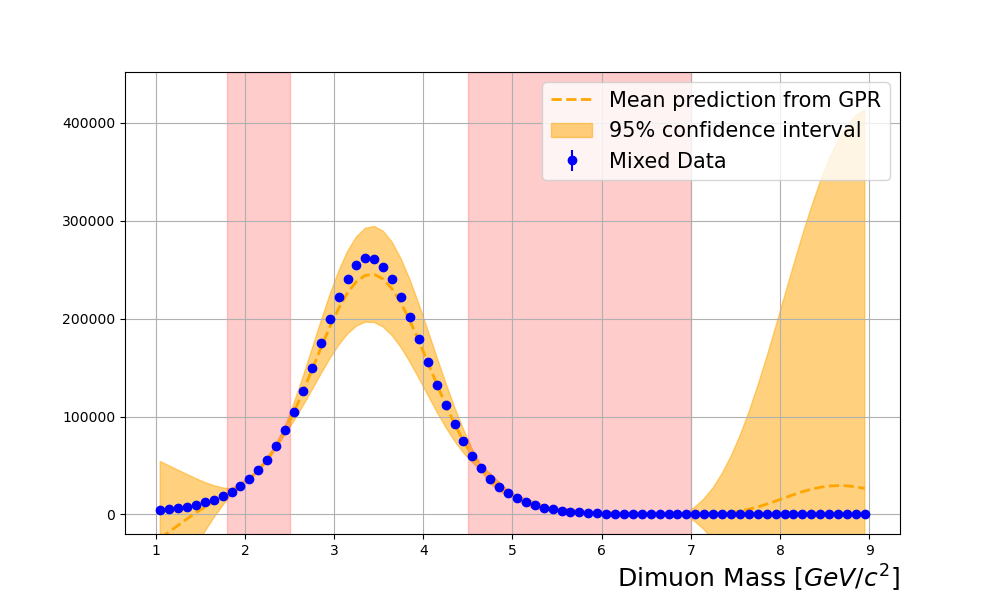

In [43]:
plot_gpr(bin_centres, mix_m, mix_m_err, Y_pred, gpr_error)

In [45]:
pT_threshold = 1.
xF_threshold = 0.5
mass_threshold = 0.

In [46]:
pT_low_mask =  (df_mix['pT']<pT_threshold)
pT_high_mask = (df_mix['pT']>pT_threshold)

xF_low_mask =  (df_mix['xF']<xF_threshold) 
xF_high_mask = (df_mix['xF']>xF_threshold)

## High xF region (xF>.5)

In [47]:
total_cut= (Dump_mix_data_cut) & (xF_high_mask) 
mix_mass_highxF=df_mix['mass'][total_cut]

mix_m_highxF, mix_m_err_highxF = fill_hist(mix_mass_highxF)


In [48]:
stacked_mix_m_highxF=np.column_stack((np.array(bin_centres),np.array(mix_m_highxF), np.array(mix_m_err_highxF)))
real_data_model.set_sideband(sideband,stacked_mix_m_highxF)
real_data_model.set_kernel(50000.0, (1e-10, 1e15),5,(1e-4, 1e15))
Y_pred_highxF, sigma_highxF, gpr_error_highxF = real_data_model.predict(5000)

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.74e+04**2 * RBF(length_scale=0.878)
score =  0.950796314185641
Log-likelihood: -227.739


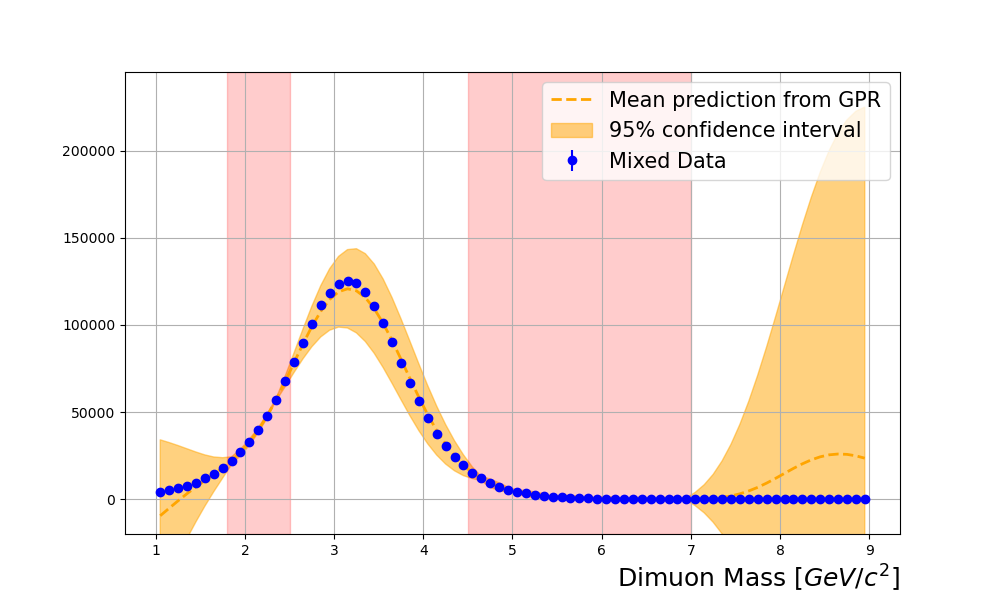

In [49]:
plot_gpr(bin_centres, mix_m_highxF, mix_m_err_highxF, Y_pred_highxF, gpr_error_highxF)

## Low xF

In [50]:
total_cut_lowxF= (Dump_mix_data_cut) & (xF_low_mask) 
mix_mass_lowxF=df_mix['mass'][total_cut_lowxF]

mix_m_lowxF, mix_m_err_lowxF = fill_hist(mix_mass_lowxF)


In [51]:
stacked_mix_m_lowxF=np.column_stack((np.array(bin_centres),np.array(mix_m_lowxF), np.array(mix_m_err_lowxF)))
real_data_model.set_sideband(sideband,stacked_mix_m_lowxF)
real_data_model.set_kernel(150000.0, (1e-10, 1e25),10,(1e-4, 1e25))
Y_pred_lowxF, sigma_lowxF, gpr_error_lowxF = real_data_model.predict(50000)

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.81e+04**2 * RBF(length_scale=0.845)
score =  0.979948385059955
Log-likelihood: -235.010


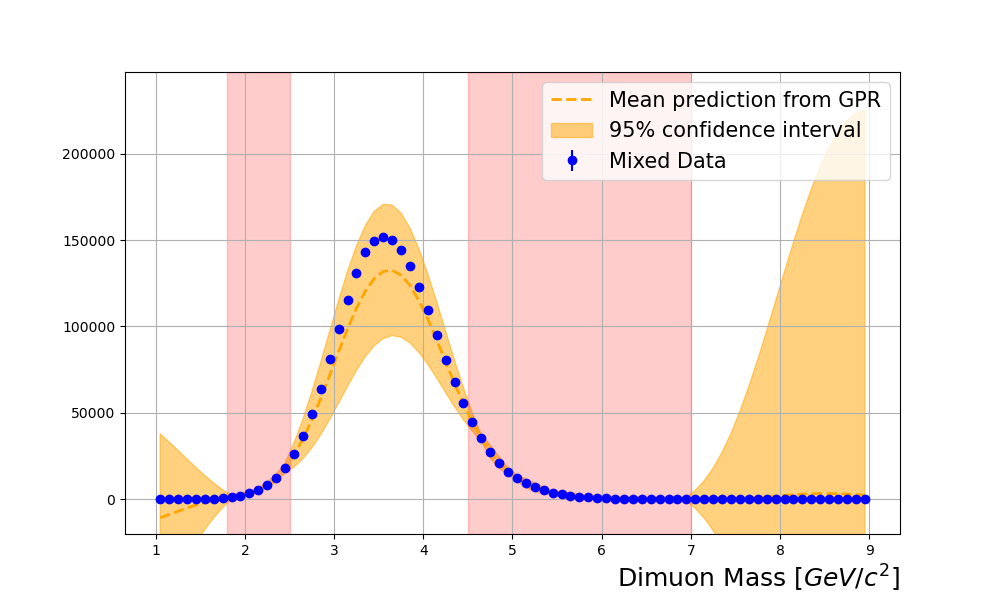

In [52]:
plot_gpr(bin_centres, mix_m_lowxF, mix_m_err_lowxF, Y_pred_lowxF, gpr_error_lowxF)

## High pT (>1.0 GeV)

In [53]:
total_cut_highpT= (Dump_mix_data_cut) & (pT_high_mask) 
mix_mass_highpT=df_mix['mass'][total_cut_highpT]

mix_m_highpT, mix_m_err_highpT = fill_hist(mix_mass_highpT)


In [54]:
stacked_mix_m_highpT=np.column_stack((np.array(bin_centres),np.array(mix_m_highpT), np.array(mix_m_err_highpT)))
real_data_model.set_sideband(sideband,stacked_mix_m_highpT)
real_data_model.set_kernel(50000.0, (1e-10, 1e15),5,(1e-4, 1e15))
Y_pred_highpT, sigma_highpT, gpr_error_highpT = real_data_model.predict(5000)

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.86e+04**2 * RBF(length_scale=0.893)
score =  0.998850836286892
Log-likelihood: -221.323


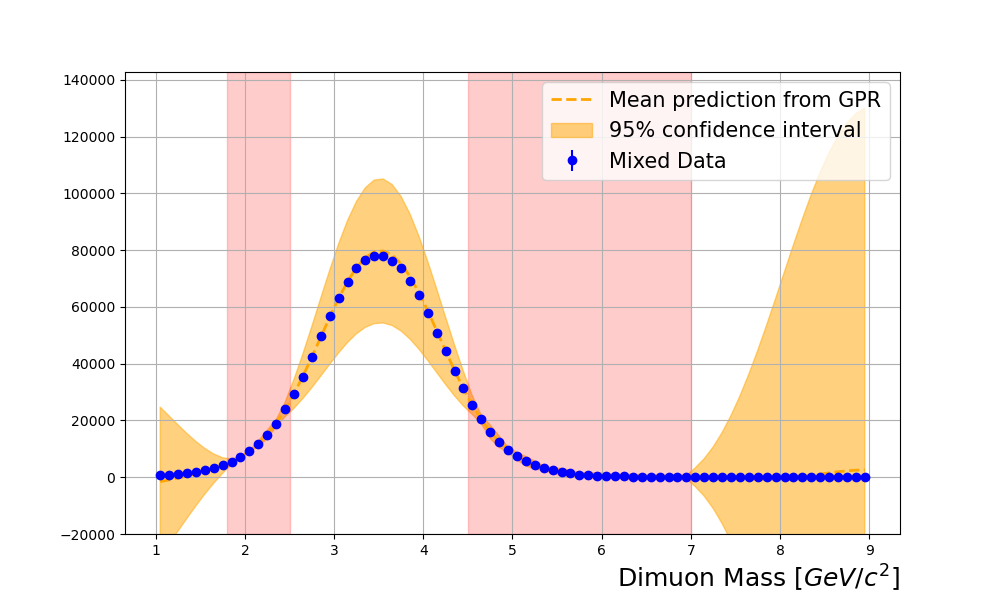

In [55]:
plot_gpr(bin_centres, mix_m_highpT, mix_m_err_highpT, Y_pred_highpT, gpr_error_highpT)

## low pT (<1. GeV)

In [27]:
total_cut_lowpT= (Dump_mix_data_cut) & (pT_low_mask) 
mix_mass_lowpT=df_mix['mass'][total_cut_lowpT]

mix_m_lowpT, mix_m_err_lowpT = fill_hist(mix_mass_lowpT)


In [28]:
stacked_mix_m_lowpT=np.column_stack((np.array(bin_centres),np.array(mix_m_lowpT), np.array(mix_m_err_lowpT)))
real_data_model.set_sideband(sideband,stacked_mix_m_lowpT)
real_data_model.set_kernel(250000.0, (1e-10, 1e15),5,(1e-4, 1e15))
Y_pred_lowpT, sigma_lowpT, gpr_error_lowpT = real_data_model.predict(5000)

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  6.3e+04**2 * RBF(length_scale=0.889)
score =  0.9757891184566926
Log-likelihood: -233.999


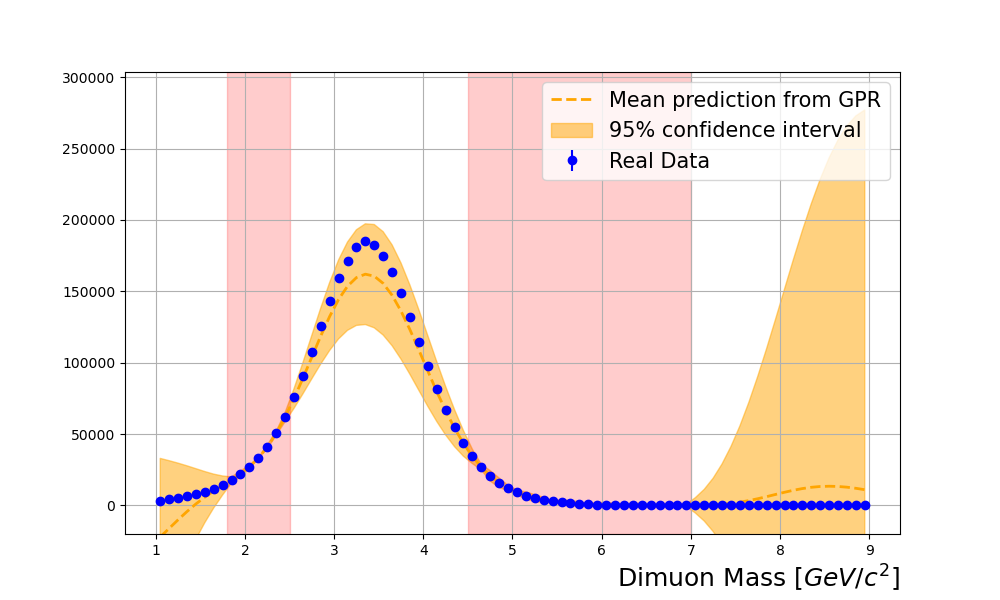

In [29]:
plot_gpr(bin_centres, mix_m_lowpT, mix_m_err_lowpT, Y_pred_lowpT, gpr_error_lowpT)